# [Variational Auto-Encoder](https://wikidocs.net/152474)
- VAE는 Input image X를 잘 설명하는 feature를 추출하여 Latent vector z에 담고, 이 Latent vector z를 통해 X와 유사하지만 완전히 새로운 데이터를 생성하는 것을 목표로 합니다.
- 이때 각 feature가 가우시안 분포를 따른다고 가정하고 latent z는각 feature의 평균과 분산값을 나타냅니다.

예를 들어 한국인의 얼굴을 그리기 위해 눈, 코, 입 등의 feature를 Latent vector z에 담고, 그 z를 이용해 그럴듯한 한국인의 얼굴을 그려내는 것입니다. latent vector z는 한국인 눈 모양의 평균 및 분산, 한국인 코 길이의 평균 및 분산, 한국인 머리카락 길이의 평균 및 분산 등등의 정보를 담고 있다고 생각할 수 있겠습니다.

## AE vs. VAE
- VAE(Variational AutoEncoder)는 기존의 AutoEncoder와 탄생 배경이 다르지만 구조가 상당히 비슷해서 Variational AE라는 이름이 붙은 것입니다.
- 즉, VAE와 AE는 엄연히 다릅니다.

### 모델 구조 비교

AutoEncoder의 목적은 Encoder에 있습니다. AE는 Encoder 학습을 위해 Decoder를 붙인 것입니다.

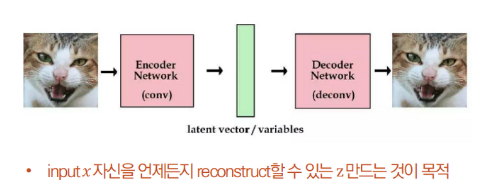

반대로 VAE의 목적은 Decoder에 있습니다. Decoder 학습을 위해 Encoder를 붙인 것입니다.

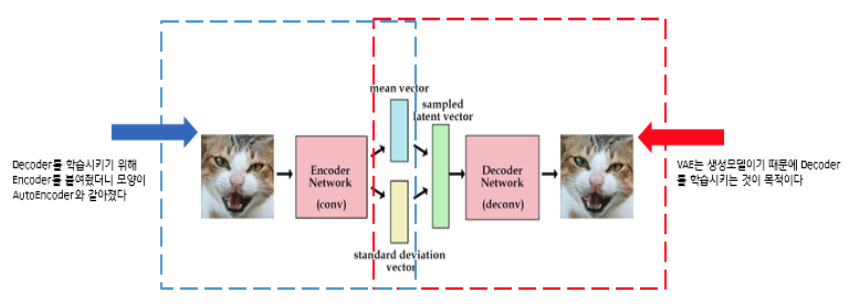

### 학습 방법 비교

VAE는 단순히 입력값을 재구성하는 AE에서 발전한 구조로 추출된 잠재 코드의 값을 하나의 숫자로 나타내는 것이 아니라, 가우시안 확률 분포에 기반한 확률값 으로 나타낸다.

- AE : 잠재 코드 값이 어떤 하나의 값
- VAE : 잠재 코드 값이 평균과 분산으로 표현되는 어떤 가우시안 분포

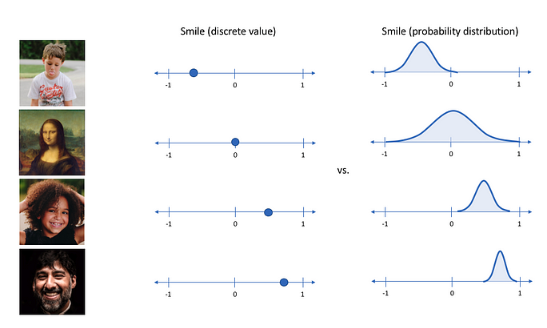

### 결론

- 아래 그림은 MNist 데이터를 각각 AE와 VAE로 특징을 추출해 표현한 그림이다. 각 점의 색깔은 MNIST 데이터인 0~9의 숫자를 나타낸다.
- AE가 만들어낸 잠재 공간은 군집이 비교적 넓게 퍼져있고, 중심으로 잘 뭉쳐있지 않지만, VAE가 만들어낸 잠재 공간은 중심으로 더 잘 뭉쳐져 있는 것을 확인 할 수 있다.

따라서 원본 데이터를 재생하는데 AE에 비해서 VAE가 더 좋은 성능을 보인다는 것을 알 수 있다. 즉 VAE를 통해서 데이터의 특징을 파악하는게 더 유리하다.

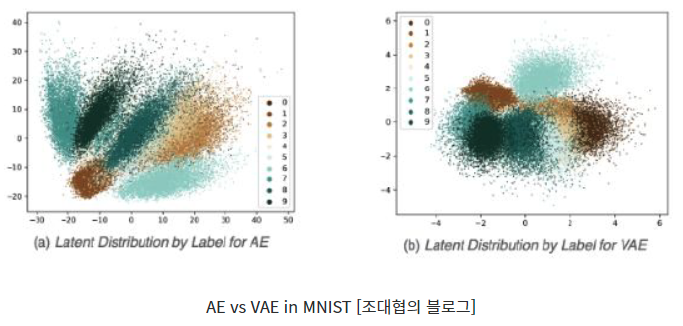

# Data

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

## Dataset

In [2]:
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)


100%|██████████| 9912422/9912422 [00:00<00:00, 110856147.43it/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 19806359.36it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32007198.48it/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20074319.04it/s]


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



## DataLoader

In [3]:
bs = 100

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)


# [VAE](https://github.com/lyeoni/pytorch-mnist-VAE/tree/master)

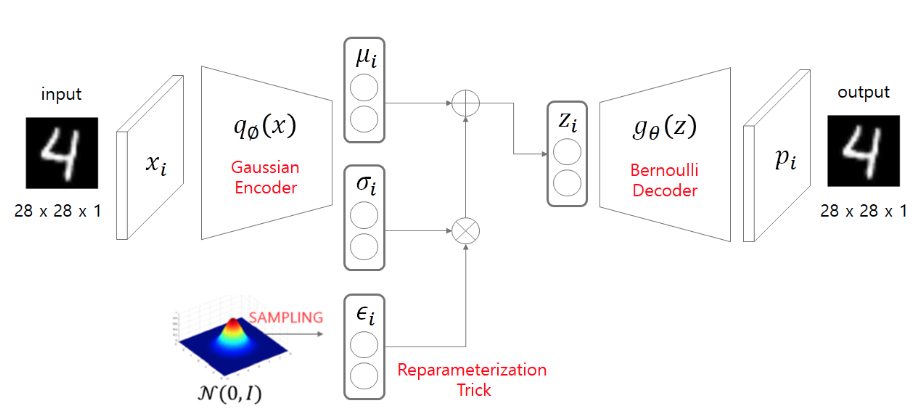

## Model

In [4]:
class Encoder(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super().__init__()

        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var

In [5]:
class Decoder(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super().__init__()

        # decoder part
        self.fc1 = nn.Linear(z_dim, h_dim2)
        self.fc2 = nn.Linear(h_dim2, h_dim1)
        self.fc3 = nn.Linear(h_dim1, x_dim)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return F.sigmoid(self.fc3(h))

In [6]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super().__init__()

        # encoder part
        self.encoder = Encoder(x_dim, h_dim1, h_dim2, z_dim)
        # decoder part
        self.decoder = Decoder(x_dim, h_dim1, h_dim2, z_dim)

    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample

    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var


## Training

In [7]:
# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
if torch.cuda.is_available():
    vae.cuda()

In [8]:
optimizer = optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [9]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()

        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [10]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.cuda()
            recon, mu, log_var = vae(data)

            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [11]:
for epoch in range(1, 51):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 545.170625
Train Epoch: 1 [10000/60000 (17%)]	Loss: 196.595879
Train Epoch: 1 [20000/60000 (33%)]	Loss: 171.306270
Train Epoch: 1 [30000/60000 (50%)]	Loss: 169.082637
Train Epoch: 1 [40000/60000 (67%)]	Loss: 162.702871
Train Epoch: 1 [50000/60000 (83%)]	Loss: 167.979492
====> Epoch: 1 Average loss: 178.9209
====> Test set loss: 162.6561
Train Epoch: 2 [0/60000 (0%)]	Loss: 154.988359
Train Epoch: 2 [10000/60000 (17%)]	Loss: 156.294053
Train Epoch: 2 [20000/60000 (33%)]	Loss: 163.302002
Train Epoch: 2 [30000/60000 (50%)]	Loss: 150.950781
Train Epoch: 2 [40000/60000 (67%)]	Loss: 146.305908
Train Epoch: 2 [50000/60000 (83%)]	Loss: 159.004648
====> Epoch: 2 Average loss: 158.2251
====> Test set loss: 154.5967
Train Epoch: 3 [0/60000 (0%)]	Loss: 154.068359
Train Epoch: 3 [10000/60000 (17%)]	Loss: 145.163291
Train Epoch: 3 [20000/60000 (33%)]	Loss: 152.412705
Train Epoch: 3 [30000/60000 (50%)]	Loss: 149.604619
Train Epoch: 3 [40000/60000 (67%)]	Loss: 152.89

## Prediction

In [13]:
with torch.no_grad():
    z = torch.randn(64, 2).cuda()
    sample = vae.decoder(z).cuda()

    save_image(sample.view(64, 1, 28, 28), 'sample_vae' + '.png')

# [Conditional VAE](https://github.com/lyeoni/pytorch-mnist-CVAE/tree/master)

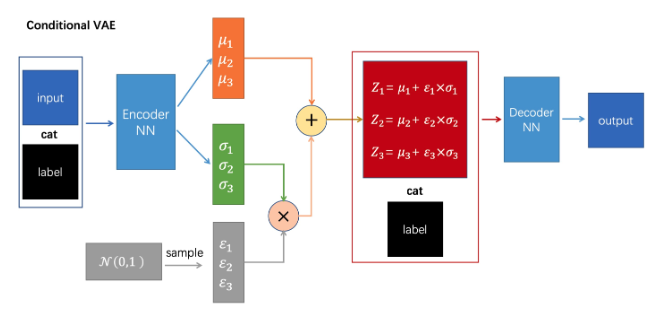

## Model

In [14]:
class Encoder(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim, c_dim):
        super().__init__()

        # encoder part
        self.fc1 = nn.Linear(x_dim + c_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)

    def forward(self, x, c):
        concat_input = torch.cat([x, c], 1)
        h = F.relu(self.fc1(concat_input))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h)

In [15]:
class Decoder(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim, c_dim):
        super().__init__()

        # decoder part
        self.fc4 = nn.Linear(z_dim + c_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)

    def forward(self, z, c):
        concat_input = torch.cat([z, c], 1)
        h = F.relu(self.fc4(concat_input))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h))


In [16]:
class CVAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim, c_dim):
        super().__init__()

        # encoder part
        self.encoder = Encoder(x_dim, h_dim1, h_dim2, z_dim, c_dim)
        # decoder part
        self.decoder = Decoder(x_dim, h_dim1, h_dim2, z_dim, c_dim)

    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add(mu) # return z sample

    def forward(self, x, c):
        mu, log_var = self.encoder(x.view(-1, 784), c)
        z = self.sampling(mu, log_var)
        return self.decoder(z, c), mu, log_var

In [17]:
# build model
cond_dim = train_loader.dataset.train_labels.unique().size(0)
cvae = CVAE(x_dim=784, h_dim1=512, h_dim2=256, z_dim=2, c_dim=cond_dim)
if torch.cuda.is_available():
    cvae.cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


## Training

In [18]:
optimizer = optim.Adam(cvae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

# one-hot encoding
def one_hot(labels, class_size):
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return Variable(targets)

In [19]:
def train(epoch):
    cvae.train()
    train_loss = 0
    for batch_idx, (data, cond) in enumerate(train_loader):
        data, cond = data.cuda(), one_hot(cond, cond_dim).cuda()
        optimizer.zero_grad()

        recon_batch, mu, log_var = cvae(data, cond)
        loss = loss_function(recon_batch, data, mu, log_var)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [20]:
def test():
    cvae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, cond in test_loader:
            data, cond = data.cuda(), one_hot(cond, cond_dim).cuda()
            recon, mu, log_var = cvae(data, cond)
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [21]:
# train
for epoch in range(1, 51):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 543.002383
Train Epoch: 1 [10000/60000 (17%)]	Loss: 176.634746
Train Epoch: 1 [20000/60000 (33%)]	Loss: 152.894766
Train Epoch: 1 [30000/60000 (50%)]	Loss: 152.220332
Train Epoch: 1 [40000/60000 (67%)]	Loss: 147.929131
Train Epoch: 1 [50000/60000 (83%)]	Loss: 152.498828
====> Epoch: 1 Average loss: 162.7327
====> Test set loss: 140.7055
Train Epoch: 2 [0/60000 (0%)]	Loss: 136.770742
Train Epoch: 2 [10000/60000 (17%)]	Loss: 141.489805
Train Epoch: 2 [20000/60000 (33%)]	Loss: 141.980771
Train Epoch: 2 [30000/60000 (50%)]	Loss: 130.842832
Train Epoch: 2 [40000/60000 (67%)]	Loss: 134.567500
Train Epoch: 2 [50000/60000 (83%)]	Loss: 140.166328
====> Epoch: 2 Average loss: 138.2837
====> Test set loss: 136.1920
Train Epoch: 3 [0/60000 (0%)]	Loss: 144.989824
Train Epoch: 3 [10000/60000 (17%)]	Loss: 129.919785
Train Epoch: 3 [20000/60000 (33%)]	Loss: 139.272354
Train Epoch: 3 [30000/60000 (50%)]	Loss: 136.280645
Train Epoch: 3 [40000/60000 (67%)]	Loss: 134.73

## Prediction

In [22]:
with torch.no_grad():
    z = torch.randn(10, 2).cuda()
    c = torch.eye(10).cuda()

    sample = cvae.decoder(z, c)
    save_image(sample.view(10, 1, 28, 28), './sample_cvae' + '.png')